In [1]:
import MeCab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import warnings
from tqdm.auto import tqdm
import seaborn as sns
warnings.filterwarnings(action='ignore')
mecab = MeCab.Tagger()

In [2]:
import pandas as pd
train_data = pd.read_csv('./steam.txt',header = 0, delimiter = '\t')

In [3]:
stop_word=[]
with open('stopwords.txt', 'r', encoding='utf-8') as f:  # 'r'은 read의 약자

    for line in f:
        stop_word.append(line.strip())
       # txt 파일안에 엔터(\n)가 있기 때문에 strip을 통해서 화이트 스페이스를 없애줍니다.

In [4]:
df=train_data[["label","document"]]
df.rename(columns={"label":"y_label","document":"review"},inplace=True)

In [5]:
df_text=df['review']
df_text=np.array(df_text)

In [6]:
from konlpy.tag import Mecab
mecab=Mecab(dicpath='C:/mecab/mecab-ko-dic')

## 명사만 뽑아오기

In [7]:
token_list=[]

for text in df['review']:
    token = mecab.pos(text)
    pos_list=[]
    for i in range(len(token)):
        if token[i][1] in ['NNG', 'NNP'] and token[i][0] not in stop_word:
            pos_list.append(token[i][0])
    token_list.append(pos_list)

In [8]:
result=pd.DataFrame(token_list)

In [9]:
df['noun']=token_list

In [10]:
df

,y_label,review,noun
0,0,노래가 너무 적음,[노래]
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다.","[황숙, 공장]"
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지,"[막노동, 체험, 판, 막노동, 사람, 장비]"
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??,"[차악, 차악, 차악, 왕국]"
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요,"[시간, 도전, 과제]"
...,...,...,...
99995,0,한글화해주면 10개산다,[한글]
99996,0,개쌉노잼 ㅋㅋ,[개]
99997,0,노잼이네요... 30분하고 지웠어요...,[잼]
99998,1,야생을 사랑하는 사람들을 위한 짧지만 여운이 남는 이야기. 영어는 그리 어렵지 않습니다.,"[야생, 사랑, 사람, 여운, 이야기, 영어]"


## 명사가 없는 행 제거

In [11]:
list1=[]
for i in df.index:
    if df['noun'][i]==[]:
        pass
    else:
        list1.append(df.iloc[i,:])

In [12]:
df=pd.DataFrame(list1)
df

,y_label,review,noun
0,0,노래가 너무 적음,[노래]
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다.","[황숙, 공장]"
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지,"[막노동, 체험, 판, 막노동, 사람, 장비]"
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??,"[차악, 차악, 차악, 왕국]"
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요,"[시간, 도전, 과제]"
...,...,...,...
99995,0,한글화해주면 10개산다,[한글]
99996,0,개쌉노잼 ㅋㅋ,[개]
99997,0,노잼이네요... 30분하고 지웠어요...,[잼]
99998,1,야생을 사랑하는 사람들을 위한 짧지만 여운이 남는 이야기. 영어는 그리 어렵지 않습니다.,"[야생, 사랑, 사람, 여운, 이야기, 영어]"


In [13]:
df.reset_index(inplace=True)

In [14]:
df['y_label'].value_counts()

0    47150
1    47105
Name: y_label, dtype: int64

## 통계적 트리밍

In [15]:
from collections import Counter

def word_count(docs):
    """ 토큰화된 문서들을 입력받아 토큰을 카운트 하고 관련된 속성을 가진 데이터프레임을 리턴합니다.
    Args:
        docs (series or list): 토큰화된 문서가 들어있는 list
    Returns:
        list: Dataframe
    """
    # 전체 코퍼스에서 단어 빈도 카운트
    word_counts = Counter()

    # 단어가 존재하는 문서의 빈도 카운트, 단어가 한 번 이상 존재하면 +1
    word_in_docs = Counter()

    # 전체 문서의 갯수
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        word_in_docs.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # 단어의 순위
    # method='first': 같은 값의 경우 먼저나온 요소를 우선
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    # 코퍼스 내 단어의 비율
    wc['percent'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')

    # 누적 비율
    # cumsum() : cumulative sum
    wc['cul_percent'] = wc['percent'].cumsum()

    temp2 = zip(word_in_docs.keys(), word_in_docs.values())
    ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
    wc = ac.merge(wc, on='word')
    
    # 전체 문서 중 존재하는 비율
    wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [16]:
wc = word_count(df['noun'])
wc

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
17,게임,34260,45580,1.0,0.084503,0.084503,0.363482
26,겜,8823,10105,2.0,0.018734,0.103237,0.093608
218,플레이,5992,6729,3.0,0.012475,0.115712,0.063572
20,때,5076,5517,4.0,0.010228,0.125940,0.053854
38,재미,4607,4857,5.0,0.009005,0.134945,0.048878
...,...,...,...,...,...,...,...
21533,민들레,1,1,21534.0,0.000002,0.999993,0.000011
21534,리하,1,1,21535.0,0.000002,0.999994,0.000011
21535,우양,1,1,21536.0,0.000002,0.999996,0.000011
21536,베인,1,1,21537.0,0.000002,0.999998,0.000011


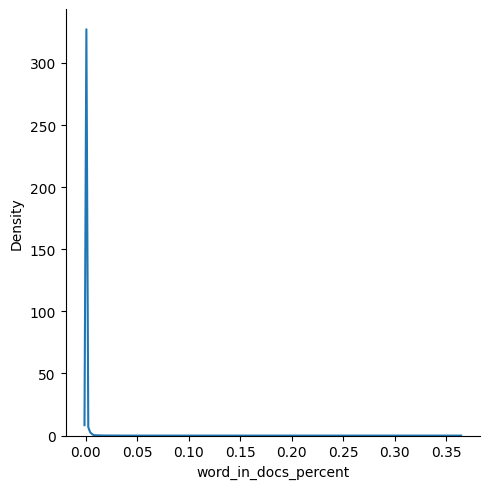

In [17]:
sns.displot(wc['word_in_docs_percent'], kind='kde');

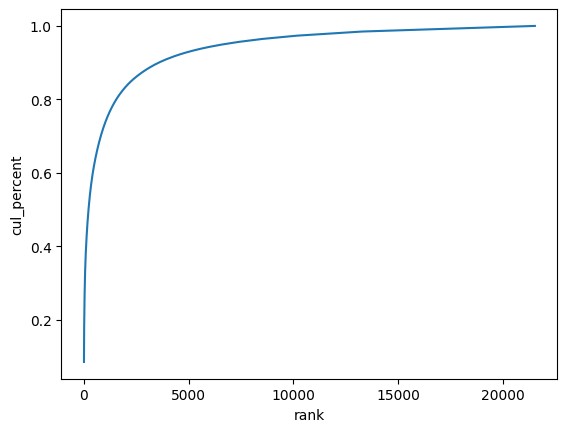

In [18]:
# 5000개 미만의 단어로 0.8 퍼센트를 차지한다.

import seaborn as sns

    # 누적분포그래프(CDF)
sns.lineplot(x='rank', y='cul_percent', data=wc);

### 최다 빈도 단어는 리뷰 분석에 필요 없다고 판단됨

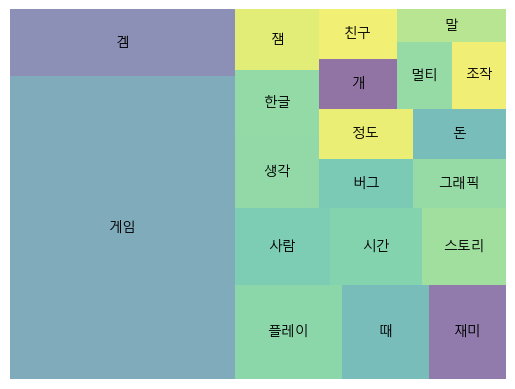

In [19]:
import matplotlib.pyplot as plt
import squarify
plt.rc('font', family='Malgun Gothic')
color=['viridis']

wc_top20 = wc[wc['rank'] <= 20]
squarify.plot(sizes=wc_top20['percent'], label=wc_top20['word'], alpha=0.6)
plt.axis('off')
plt.show()


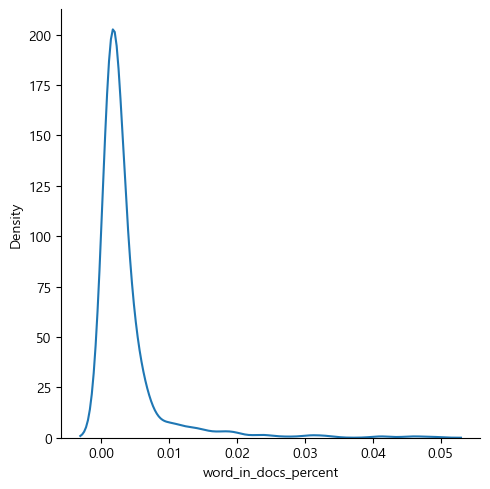

In [20]:
# 최소한 1% 이상 문서에 나타나는 단어들만 선택하고 0.05보다 작은 단어를 선택하여 게임이나 겜 등 리뷰 분석에 불필요한 단어 제거

wc = wc[wc['word_in_docs_percent'] >= 0.001]
wc = wc[wc['word_in_docs_percent'] <= 0.05]

sns.displot(wc['word_in_docs_percent'], kind='kde');

In [21]:
wc

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
38,재미,4607,4857,5.0,0.009005,0.134945,0.048878
5,사람,4386,4842,6.0,0.008977,0.143922,0.046533
12,시간,4269,4714,7.0,0.008739,0.152661,0.045292
231,스토리,3930,4308,8.0,0.007987,0.160648,0.041695
58,생각,3839,4154,9.0,0.007701,0.168349,0.040730
...,...,...,...,...,...,...,...
1495,커뮤니티,96,98,870.0,0.000182,0.712415,0.001019
866,환,96,97,873.0,0.000180,0.712954,0.001019
1235,요청,95,97,874.0,0.000180,0.713134,0.001008
1970,모험,96,97,875.0,0.000180,0.713314,0.001019


In [22]:
df['noun2'] = df['noun'].apply(lambda words: ' '.join([word for word in words if word in wc['word'].values]))

In [23]:
df

,index,y_label,review,noun,noun2
0,0,0,노래가 너무 적음,[노래],노래
1,1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다.","[황숙, 공장]",
2,2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지,"[막노동, 체험, 판, 막노동, 사람, 장비]",체험 판 사람 장비
3,3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??,"[차악, 차악, 차악, 왕국]",
4,4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요,"[시간, 도전, 과제]",시간 도전 과제
...,...,...,...,...,...
94250,99995,0,한글화해주면 10개산다,[한글],한글
94251,99996,0,개쌉노잼 ㅋㅋ,[개],개
94252,99997,0,노잼이네요... 30분하고 지웠어요...,[잼],잼
94253,99998,1,야생을 사랑하는 사람들을 위한 짧지만 여운이 남는 이야기. 영어는 그리 어렵지 않습니다.,"[야생, 사랑, 사람, 여운, 이야기, 영어]",사랑 사람 이야기 영어


In [24]:
final=df[['noun2','y_label']]
final.columns=['text','label']

In [25]:
# 문장 띄어쓰기별로 리스트로 만들기 함수
def func2(x):
    import itertools
    texts = [x.split(' ')]
    texts = list(itertools.chain(*texts))
    return texts

In [26]:
df4=final
df4

,text,label
0,노래,0
1,,0
2,체험 판 사람 장비,1
3,,1
4,시간 도전 과제,1
...,...,...
94250,한글,0
94251,개,0
94252,잼,0
94253,사랑 사람 이야기 영어,1


In [27]:
m0=df4['label']==0
df0=df4[m0]
df0=df0.dropna()
df0=df0.reset_index(drop=True)

In [28]:
list0=[]
for i in range(len(df0)):
    list0.append(func2(df0['text'][i]))

In [29]:
df0['text_to_list']=list0

In [30]:
wc0 = word_count(df0['text_to_list'])
wc0.columns=['word','word_in_docs','count','rank','percent','cul_percent','word_in_docs_percent']

In [31]:
wc0_2=wc0.sort_values('word_in_docs_percent', ascending=False)
len(wc0)

855

In [32]:
wc0

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
1,,4296,4296,1.0,0.025705,0.025705,0.091113
51,사람,2235,2473,2.0,0.014797,0.040503,0.047402
4,버그,1976,2364,3.0,0.014145,0.054648,0.041909
47,돈,2169,2333,4.0,0.013960,0.068608,0.046002
90,재미,2171,2292,5.0,0.013714,0.082322,0.046045
...,...,...,...,...,...,...,...
794,한편,19,19,851.0,0.000114,0.999707,0.000403
841,흠,16,16,852.0,0.000096,0.999803,0.000339
854,굳,13,14,853.0,0.000084,0.999886,0.000276
644,굿,12,12,854.0,0.000072,0.999958,0.000255


## 1번라벨 많이 나오는 단어

In [33]:
m1=df4['label']==1
df1=df4[m1]
df1=df1.dropna()
df1=df1.reset_index(drop=True)

In [34]:
list1=[]
for i in range(len(df1)):
    list1.append(func2(df1['text'][i]))

In [35]:
df1['text_to_list']=list1

In [36]:
wc1 = word_count(df1['text_to_list'])
wc1.columns=['word','word_in_docs','count','rank','percent','cul_percent','word_in_docs_percent']

In [37]:
wc1
wc1_2=wc1.sort_values('word_in_docs_percent', ascending=False)
len(wc1)

855

In [38]:
w0_top50=wc0_2.head(70)

In [39]:
w1_top50=wc1_2.head(70)

In [40]:
w0_top50['only'] = w0_top50['word'].apply(lambda word: word if word not in w1_top50['word'].values else '')

In [41]:
w1_top50['only'] = w1_top50['word'].apply(lambda word: word if word not in w0_top50['word'].values else '')

In [42]:
w0_top50=w0_top50.reset_index()
w1_top50=w1_top50.reset_index()

In [43]:
list1=[]
list2=[]
for i in w0_top50.index:
    if w0_top50['only'][i]!='':
        list1.append(w0_top50.iloc[i,:])

for i in w1_top50.index:
    if w1_top50['only'][i]!='':
        list2.append(w1_top50.iloc[i,:])
        
only0=pd.DataFrame(list1)
only1=pd.DataFrame(list2)

In [44]:
wc_no_graph=only0
wc_yes_graph=only1

wc_no_graph_doc=wc_no_graph.copy()
wc_yes_graph_doc=wc_yes_graph.copy()

wc_no_graph['percent']=wc_no_graph['percent']*100
wc_yes_graph['percent']=wc_yes_graph['percent']*100

wc_no_graph_doc=wc_no_graph_doc.sort_values(by=['word_in_docs_percent'], ascending=False)
wc_yes_graph_doc=wc_yes_graph_doc.sort_values(by=['word_in_docs_percent'], ascending=False)



wc_no_graph_doc['word_in_docs_percent']=wc_no_graph_doc['word_in_docs_percent']*100
wc_yes_graph_doc['word_in_docs_percent']=wc_yes_graph_doc['word_in_docs_percent']*100

In [45]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
import numpy as np
from PIL import *

In [46]:
cand_mask=np.array(Image.open('comment.png'))

In [47]:
wc_no_cloud=wc0.head(100)
wc_yes_cloud=wc1.head(100)

In [48]:
wc_no_cloud=wc_no_cloud[["word","count"]].reset_index()
wc_yes_cloud=wc_yes_cloud[["word","count"]].reset_index()

In [49]:
x_no=wc_no_cloud['word']
x_yes=wc_yes_cloud['word']

In [50]:
result_no = list(set(x_no) - set(x_yes))
result_yes = list(set(x_yes) - set(x_no))

In [51]:
list1=[]
for i in wc_no_cloud.index:
    if wc_no_cloud['word'][i] in result_no:
        list1.append(wc_no_cloud.iloc[i,:])

In [52]:
list2=[]
for i in wc_yes_cloud.index:
    if wc_yes_cloud['word'][i] in result_yes:
        list2.append(wc_yes_cloud.iloc[i,:])

In [53]:
wc_no_cloud_new=pd.DataFrame(list1)[['word','count']]
wc_yes_cloud_new=pd.DataFrame(list2)[['word','count']]

In [54]:
wc_no_cloud_new.set_index("word",inplace=True)
wc_yes_cloud_new.set_index("word",inplace=True)

In [55]:
wc_no_dict=wc_no_cloud_new.to_dict()
wc_no_dict=wc_no_dict['count']

In [56]:
wc_yes_dict=wc_yes_cloud_new.to_dict()
wc_yes_dict=wc_yes_dict['count']

In [57]:
wordcloud = WordCloud(
    font_path='malgun',
    background_color='white', # 배경색은 흰색으로 
    colormap='Reds', # 글씨색은 빨간색으로
    mask=cand_mask, # 워드클라우드 모양 설정
).generate_from_frequencies(wc_no_dict)

(-0.5, 2047.5, 2047.5, -0.5)

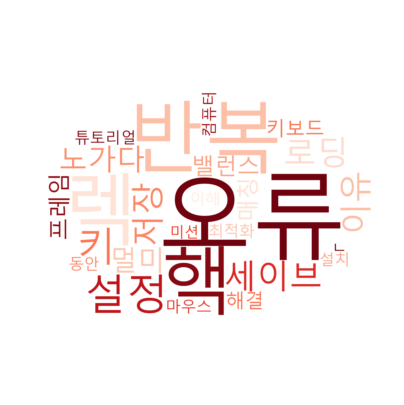

In [58]:
#사이즈 설정 및 출력
plt.figure(figsize=(5,5))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off') # 차트로 나오지 않게
#plt.savefig('test.png')

In [59]:
wordcloud = WordCloud(
    font_path='malgun',
    background_color='white', # 배경색은 흰색으로 
    colormap='Blues', # 글씨색은 빨간색으로
    mask=cand_mask, # 워드클라우드 모양 설정
).generate_from_frequencies(wc_yes_dict)

(-0.5, 2047.5, 2047.5, -0.5)

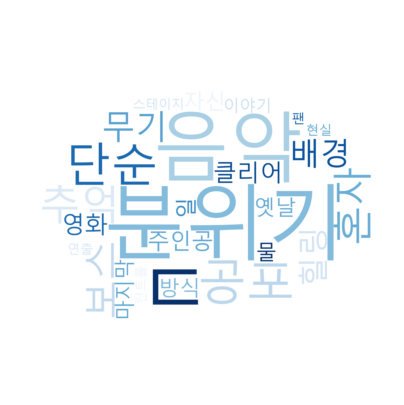

In [60]:
#사이즈 설정 및 출력
plt.figure(figsize=(5,5))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off') # 차트로 나오지 않게
#plt.savefig('test.png')

In [61]:
df_final_0=df['y_label']==0
df_final0=df[df_final_0]
df_final0

df_final_1=df['y_label']==1
df_final1=df[df_final_1]
df_final1

,index,y_label,review,noun,noun2
2,2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지,"[막노동, 체험, 판, 막노동, 사람, 장비]",체험 판 사람 장비
3,3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??,"[차악, 차악, 차악, 왕국]",
4,4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요,"[시간, 도전, 과제]",시간 도전 과제
5,5,1,역시 재미있네요 전작에서 할수 없었던 자유로운 덱 빌딩도 좋네요^^,"[전작, 자유, 덱, 빌딩]",전작 자유
6,7,1,은근 쉽지만 은근 어려운 게임,[게임],
...,...,...,...,...,...
94244,99988,1,소프트웨어를 만들고 회사를 키우는 게임입니다. 난이도는 중상정도 되는 것 같고 한국...,"[소프트웨어, 회사, 게임, 난이도, 중상, 정도, 한국어, 패치, 창작, 마당, 게임]",회사 난이도 정도 한국어 패치 창작 마당
94245,99989,1,꿀잼보장갬,"[꿀, 잼]",꿀 잼
94247,99992,1,찌찌 배구,"[찌찌, 배구]",
94253,99998,1,야생을 사랑하는 사람들을 위한 짧지만 여운이 남는 이야기. 영어는 그리 어렵지 않습니다.,"[야생, 사랑, 사람, 여운, 이야기, 영어]",사랑 사람 이야기 영어


In [62]:
df_final0=df_final0.reset_index()
df_final1=df_final1.reset_index()

In [63]:
list100=[]
for i in df_final0.index:
    if df_final0['noun2'][i]!='':
        list100.append(df_final0.iloc[i,:])
list101=[]
for i in df_final1.index:
    if df_final1['noun2'][i]!='':
        list101.append(df_final1.iloc[i,:])

In [64]:
df_final0=pd.DataFrame(list100)
df_final1=pd.DataFrame(list101)

In [65]:
len(df_final1)

41347

In [66]:
# import pandas as pd

# # df_final1과 df_final0의 길이가 다른 경우에만 작업을 수행합니다.
# if len(df_final1) != len(df_final0):
#     # 두 데이터프레임 중에서 길이가 더 짧은 쪽의 길이를 구합니다.
#     min_length = min(len(df_final1), len(df_final0))
    
#     # 길이를 맞추기 위해 두 데이터프레임을 잘라냅니다.
#     df_final1 = df_final1[:min_length]
#     df_final0 = df_final0[:min_length]

In [67]:
import numpy as np
from sklearn.model_selection import train_test_split
import itertools
X_train_0, X_test_0, Y_train_0, Y_test_0 = train_test_split(df_final0['noun2'], df_final0['y_label'], test_size=0.2, random_state=1004)
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(df_final1['noun2'], df_final1['y_label'], test_size=0.2, random_state=1004)

In [68]:
len(X_train_1)

33077

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import vstack

# TfidfVectorizer를 생성
tf_idf = TfidfVectorizer()

# 클래스 0의 데이터를 벡터화하고 분리
X_train_tf_0 = tf_idf.fit_transform(X_train_0)
X_test_tf_0 = tf_idf.transform(X_test_0)

# 클래스 1의 데이터를 벡터화하고 분리
X_train_tf_1 = tf_idf.transform(X_train_1)
X_test_tf_1 = tf_idf.transform(X_test_1)

# 벡터화된 데이터를 수직으로 합치기
X_train_combined = vstack([X_train_tf_0, X_train_tf_1])
X_test_combined = vstack([X_test_tf_0, X_test_tf_1])

In [70]:
X_train_combined

<67360x653 sparse matrix of type '<class 'numpy.float64'>'
	with 182120 stored elements in Compressed Sparse Row format>

In [71]:
Y_train_combined = pd.concat([Y_train_0, Y_train_1], ignore_index=True)
Y_test_combined = pd.concat([Y_test_0, Y_test_1], ignore_index=True)
Y_train_combined

0        0
1        0
2        0
3        0
4        0
        ..
67355    1
67356    1
67357    1
67358    1
67359    1
Name: y_label, Length: 67360, dtype: int64

In [72]:
# import numpy as np
# from sklearn.model_selection import train_test_split
# import itertools
# X_train, X_test, Y_train, Y_test = train_test_split(df['noun2'], df['y_label'], test_size=0.2, random_state=42)


In [73]:
# Tf-idf로 feature vectorizer 시킨 후 로지스틱리그레션 해보기
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# X_train_tf = tf_idf.fit_transform(X_train_combined)
# X_test_tf = tf_idf.transform(X_test_combined)

lr_clf = LogisticRegression()
lr_clf.fit(X_train_combined, Y_train_combined)
y_pred = lr_clf.predict(X_test_combined)
acc = accuracy_score(Y_test_combined, y_pred)
print(f"Tf-idf 벡터화 후 정확도 :{acc : .4f}")

Tf-idf 벡터화 후 정확도 : 0.6350


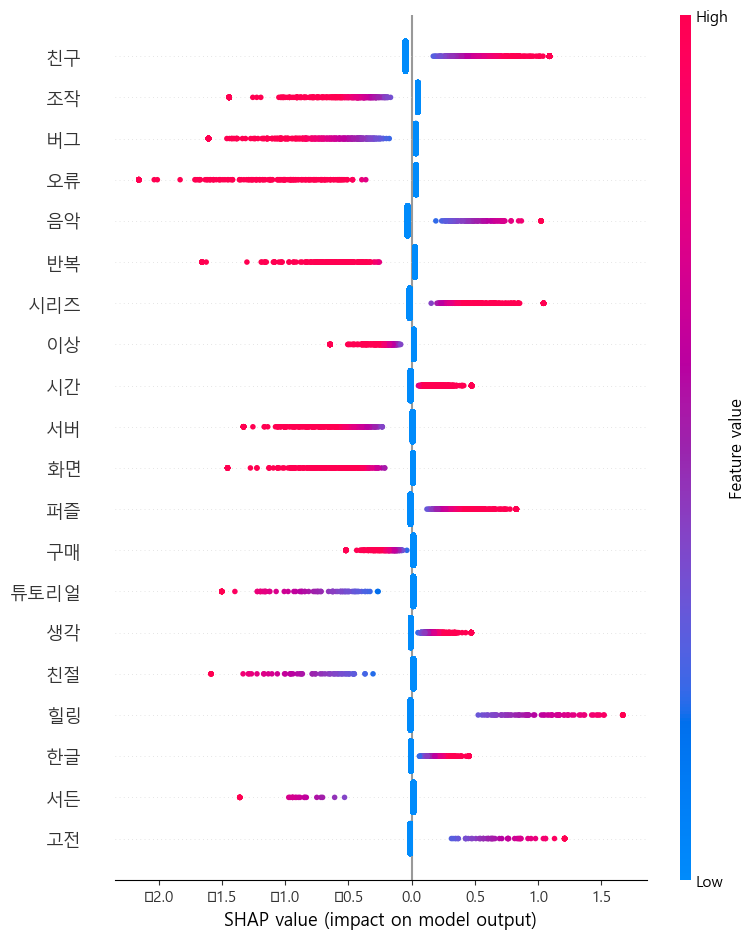

In [74]:
#pip install shap
import shap


#lr_clf 대신 model 변수 넣기
explainer = shap.LinearExplainer(lr_clf, X_test_combined, feature_dependence="independent")
shap_values = explainer.shap_values(X_test_combined)
X_test_array = X_test_combined.toarray()


#feature_names에는 X_column 리스트로 넣으면 됩니다.
shap.summary_plot(shap_values, X_test_array, feature_names=tf_idf.get_feature_names_out())

X_train_array= X_train_combined.toarray()
## 설명변수
ind = 0
shap.initjs()
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_train_array[ind,:],
    feature_names=tf_idf.get_feature_names_out()
)